In [1]:
# # Install the latest version of author's repo neural ode implementation
# !git clone https://github.com/rtqichen/torchdiffeq.git
# !cd torchdiffeq && pip install -e .
# !ls torchdiffeq/torchdiffeq

In [6]:
# importing libraries
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from torchdiffeq import odeint, odeint_adjoint
from stockDataTransformer import stockDataTransformer

# FileName
tickerName = 'Apple'
# Filepath
filepath = f"raw-stock-data/{tickerName}.csv"
# Get the data in the required format
data = stockDataTransformer(filepath)

# Total Data Size
data_size = data.shape[0]

def get_median(array, axis = 1):
    # https://numpy.org/doc/stable/reference/generated/numpy.median.html
    return np.median(array, axis = axis).reshape(data_size, 1)  #, keepdims=True)

median_data = get_median(data)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# Median data for each week
print(median_data.shape)
print(pd.DataFrame(median_data, columns = ['median_stockprice_week']).head(10))

# Convert median_data to (n_samples, 5) matrix
data_m1 = series_to_supervised(median_data, 4).values
print(data_m1.shape)
print(pd.DataFrame(data_m1, columns = ['week(t-4)', 'week(t-3)', 'week(t-2)', 'week(t-1)', 'week(t)']).head(20))

(506, 1)
   median_stockprice_week
0                6.522572
1                6.432569
2                6.384427
3                6.225123
4                5.997283
5                6.049106
6                6.187098
7                6.240301
8                6.642778
9                6.888709
(502, 5)
    week(t-4)  week(t-3)  week(t-2)  week(t-1)   week(t)
0    6.522572   6.432569   6.384427   6.225123  5.997283
1    6.432569   6.384427   6.225123   5.997283  6.049106
2    6.384427   6.225123   5.997283   6.049106  6.187098
3    6.225123   5.997283   6.049106   6.187098  6.240301
4    5.997283   6.049106   6.187098   6.240301  6.642778
5    6.049106   6.187098   6.240301   6.642778  6.888709
6    6.187098   6.240301   6.642778   6.888709  6.890396
7    6.240301   6.642778   6.888709   6.890396  7.080826
8    6.642778   6.888709   6.890396   7.080826  7.292260
9    6.888709   6.890396   7.080826   7.292260  7.421818
10   6.890396   7.080826   7.292260   7.421818  7.603969
11   7.08082

In [8]:
# size of the data
data_size = data_m1.shape[0]
dim_input = data_m1.shape[1]
# batch time and batch size
batch_time = 6  # time steps ahead that we need to predict, for each training sample
train_size = int(0.8*data_size)  # training size
print(f"training size is {train_size}")
test_size = data_size - train_size
print(f"test size is {test_size}")
niters = 2000  # training epochs
test_freq = 50
viz = True

training size is 401
test size is 101


In [11]:
# Convert to tensor
# https://pytorch.org/docs/stable/generated/torch.from_numpy.html
data_torch = torch.from_numpy(data_m1)  # https://pytorch.org/docs/stable/generated/torch.from_numpy.html
# true_y.shape
# Reshape it to get in (m, 1, dim_input)
data_torch = torch.reshape(data_torch, (data_size, 1, dim_input))  # https://pytorch.org/docs/stable/generated/torch.reshape.html
print(data_torch.shape)

# predictions on test_data's time size (test_size-batch_time, 1)
# Time steps
t = torch.linspace(0., test_size-batch_time, test_size-batch_time)
print(t.shape)

# # Initial value
# true_y0 = torch.reshape(true_y[0:batch_size], (batch_size, 1, dim))
# # true_y0


torch.Size([502, 1, 5])
torch.Size([95])


In [12]:
torch.arange(0, train_size-batch_time)

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [16]:
torch.arange(train_size, data_size-batch_time)

tensor([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
        415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442,
        443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,
        457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484,
        485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495])

In [18]:
def get_batch(mode):
    if mode == 'train:':
        # Get mini batches
        s = torch.arange(0, train_size-batch_time)  # https://pytorch.org/docs/stable/generated/torch.arange.html
        # Get the #s initial values from data 
        batch_y0 = data_torch[s]  # (M, D): m = number of examples, D = dimension
    elif mode == 'test':
        s = torch.arange(train_size, data_size-batch_time)
        batch_y0 = data_torch[s]
    # The time steps ahead for each sample
    batch_t = t[:batch_time]  # (T)
    # For each initial value, we will have T values 
    batch_y = torch.stack([data_torch[s + i] for i in range(0, batch_time)], dim=0)  # (T, M, D)
    # batch_y = torch.reshape(batch_y, (batch_time, batch_size, 1, 1))
    return batch_y0, batch_t, batch_y

In [90]:
# s = torch.arange(0, batch_size+0)

In [91]:
# true_y.shape

In [92]:
# true_y[s+5].shape

In [93]:
batch_y0, batch_t, batch_y = get_batch('train')
print(batch_t.shape)
print(batch_y0.shape)
print(batch_y.shape)

torch.Size([5])
torch.Size([200, 1, 5])
torch.Size([5, 200, 1, 5])


In [94]:
# batch_y0

In [95]:
# batch_y

In [96]:
# torch.reshape(batch_y, (batch_time, batch_size, 1, 1))

In [97]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, dim),
        )
        self.net = self.net.double()
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
# func = ODEFunc()

def visualize(t, true_y, pred_y, odefunc, itr):
  
    if viz:
      
        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--')
        # plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()
        
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [98]:
# batch_y.shape

In [99]:
# pred_y.shape

In [100]:
ii = 0
niters = 1000

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch(0)
    pred_y = odeint(func, batch_y0, batch_t)
    # print(pred_y.shape)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())
    if itr%50==0:
        with torch.no_grad():
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            # visualize(batch_t, batch_y, pred_y, func, ii)

#     if itr % 50 == 0:
#         with torch.no_grad():
#             pred_y = odeint(func, true_y0, t)
#             print(pred_y.shape)
#             loss = torch.mean(torch.abs(pred_y - true_y))
#             print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
#             visualize(true_y, pred_y, func, ii)
#             ii += 1

    end = time.time()

Iter 0050 | Total Loss 0.606091
Iter 0100 | Total Loss 0.593498
Iter 0150 | Total Loss 0.559316
Iter 0200 | Total Loss 0.511749
Iter 0250 | Total Loss 0.541931
Iter 0300 | Total Loss 0.504318
Iter 0350 | Total Loss 0.534582
Iter 0400 | Total Loss 0.528441
Iter 0450 | Total Loss 0.478669
Iter 0500 | Total Loss 0.474686
Iter 0550 | Total Loss 0.473845
Iter 0600 | Total Loss 0.476809
Iter 0650 | Total Loss 0.471579
Iter 0700 | Total Loss 0.462885
Iter 0750 | Total Loss 0.463534
Iter 0800 | Total Loss 0.480760
Iter 0850 | Total Loss 0.454909
Iter 0900 | Total Loss 0.447412
Iter 0950 | Total Loss 0.462135
Iter 1000 | Total Loss 0.444028


In [101]:
# Initial value
test_y = torch.reshape(true_y[batch_size:batch_size*2], (batch_size, 1, dim))
# print(test_y)

# Time steps
t = torch.linspace(1., 5., 5)
pred_y = odeint(func, test_y, t)

In [102]:
pred_y.shape

torch.Size([5, 200, 1, 5])

In [107]:
pred_y[0][0].shape

torch.Size([1, 5])

In [118]:
pd.DataFrame(data_m1).head(20)

,0,1,2,3,4
0,6.522572,6.432569,6.384427,6.225123,5.997283
1,6.432569,6.384427,6.225123,5.997283,6.049106
2,6.384427,6.225123,5.997283,6.049106,6.187098
3,6.225123,5.997283,6.049106,6.187098,6.240301
4,5.997283,6.049106,6.187098,6.240301,6.642778
5,6.049106,6.187098,6.240301,6.642778,6.888709
6,6.187098,6.240301,6.642778,6.888709,6.890396
7,6.240301,6.642778,6.888709,6.890396,7.080826
8,6.642778,6.888709,6.890396,7.080826,7.292260
9,6.888709,6.890396,7.080826,7.292260,7.421818


In [114]:
pred_y.detach().numpy()[0, :, 0, 0].shape

(200,)

In [117]:
true_y.numpy().shape

(502, 1, 5)

In [127]:
# Initial value
test_y = torch.reshape(true_y[:batch_size], (batch_size, 1, dim))
# print(test_y)

# Time steps
t = torch.linspace(1., 5., 5)
pred_y = odeint(func, test_y, t)

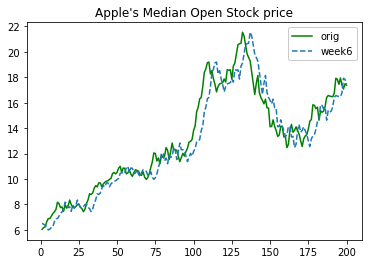

In [128]:
# W6th median prediction
t = torch.linspace(1., batch_size, batch_size)
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[5:205, 0, 0], 'g', label = 'orig')
plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 0], '--', label = 'week6')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 1], '--', label = 'week7')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 2], '--', label = 'week8')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 3], '--', label = 'week9')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 4], '--', label = 'week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

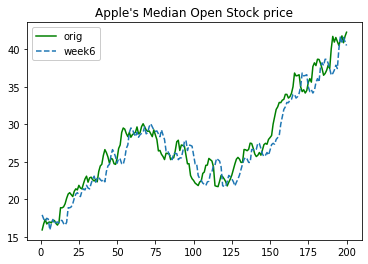

In [120]:
# W6th median prediction
t = torch.linspace(1., batch_size, batch_size)
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[205:405, 0, 0], 'g', label = 'orig')
plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 0], '--', label = 'week6')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 1], '--', label = 'week7')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 2], '--', label = 'week8')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 3], '--', label = 'week9')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 4], '--', label = 'week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

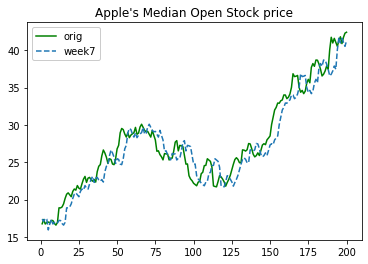

In [121]:
# W6th median prediction
t = torch.linspace(1., batch_size, batch_size)
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[206:406, 0, 0], 'g', label = 'orig')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 0], '--', label = 'week6')
plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 1], '--', label = 'week7')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 2], '--', label = 'week8')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 3], '--', label = 'week9')
# plt.plot(t.numpy(), pred_y.detach().numpy()[0,:, 0, 4], '--', label = 'week10')
plt.title(f"Apple's Median Open Stock price")
plt.legend(framealpha=1, frameon=True);
plt.show()

In [123]:
true_y[205]

tensor([[15.9389, 16.7556, 17.3313, 16.7315, 16.9359]], dtype=torch.float64)

In [126]:
pred_y[0][0]

tensor([[17.9435, 17.3982, 17.0787, 17.4903, 17.3796]], dtype=torch.float64,
       grad_fn=<SelectBackward>)